In [1002]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, is_outlier

### Read in clean .CSV data

In [1003]:
house_train = pd.read_csv('../datasets/house_train_clean.csv')

### Make DataFrames wide

In [1004]:
pd.set_option('display.max_columns', 100)

Modify ORDINAL, NOMINAL, CONTINUOUS and DISCRETE variables based on whatever info we've dropped or kept from the first notebook

In [1005]:
ORDINAL = [x for x in ORDINAL if x in house_train.columns]
NOMINAL = [x for x in NOMINAL if x in house_train.columns]
CONTINUOUS = [x for x in CONTINUOUS if x in house_train.columns]
DISCRETE = [x for x in DISCRETE if x in house_train.columns]

# Remove Outliers Based on Z-Score

In [1006]:
# remove saleprice outliers 
house_train = house_train[~is_outlier(house_train.lot_area)];

# consider log-transformation instead
house_train = house_train[~is_outlier(house_train.saleprice)];


c:\Users\alexs\Documents\dsir-1031\projects\project_2\code\cleaning_script.py:57: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


# Plot saleprice with Outliers Removed

<AxesSubplot:ylabel='Frequency'>

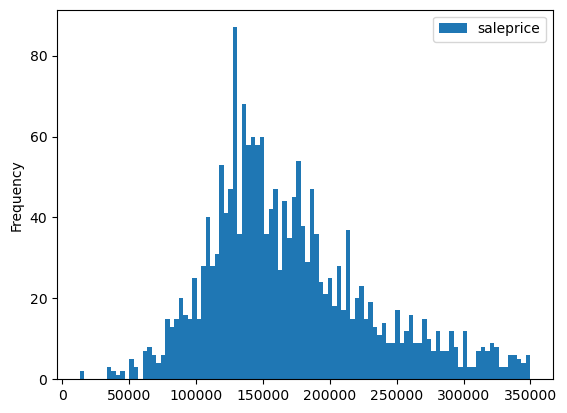

In [1007]:
house_train.plot.hist(y='saleprice', bins=100)

# Look for Correlations within Numerical Categories

In [1008]:
# create helper function for plotting correlations
corr_vals = {}
def plot_corr_heatmap(CATEGORY, title):
    COLUMNS = [x for x in CATEGORY]
    COLUMNS.append('saleprice')

    fig, ax = plt.subplots(figsize=(12,12))
    corr = house_train[COLUMNS].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.title(f'{title} Correlations')
    return sns.heatmap(corr, mask=mask, annot=True), corr['saleprice']

# dictionary of correlative factors
correlative_factors = {}

### Discrete

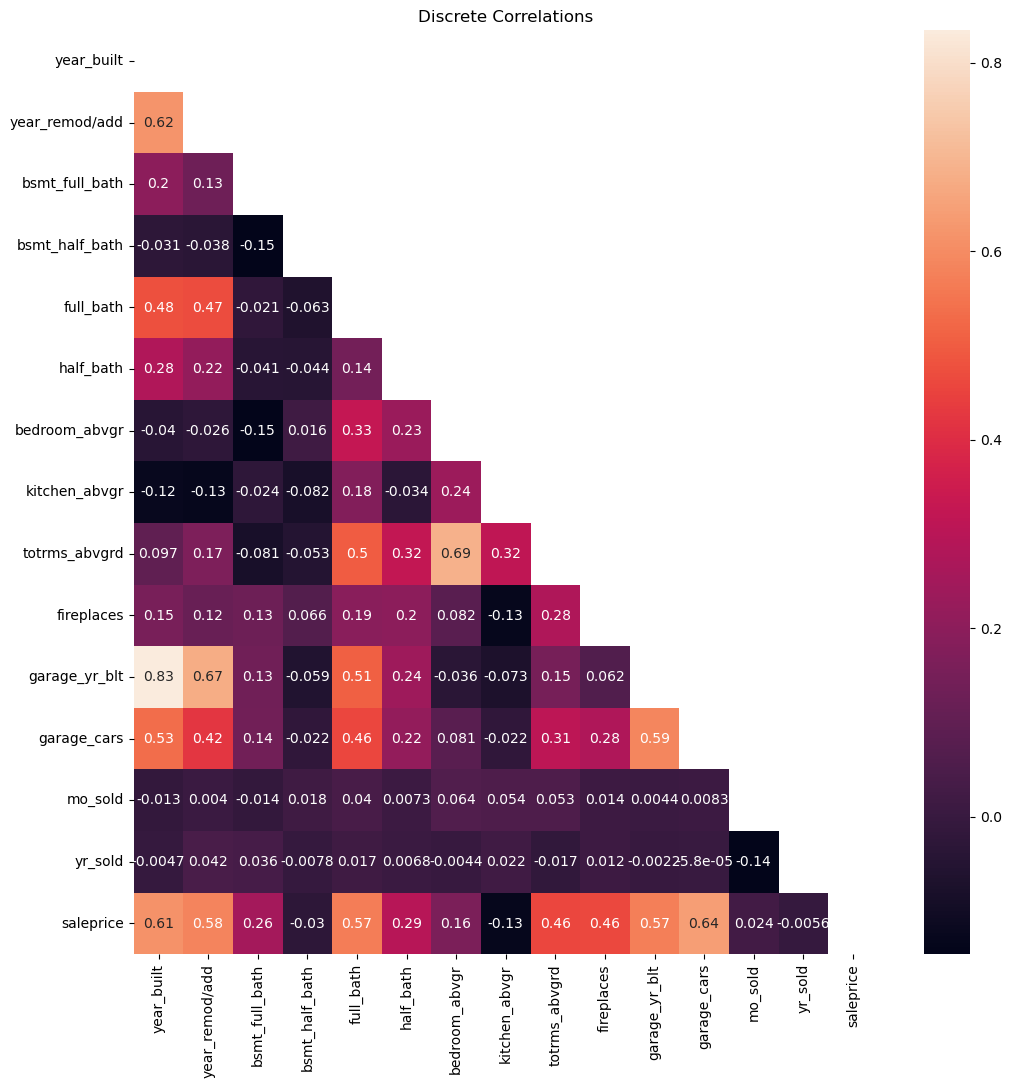

In [1009]:
discrete_corrs = plot_corr_heatmap(DISCRETE, 'Discrete')

correlative_factors.update(discrete_corrs[1].to_dict())

### Continous

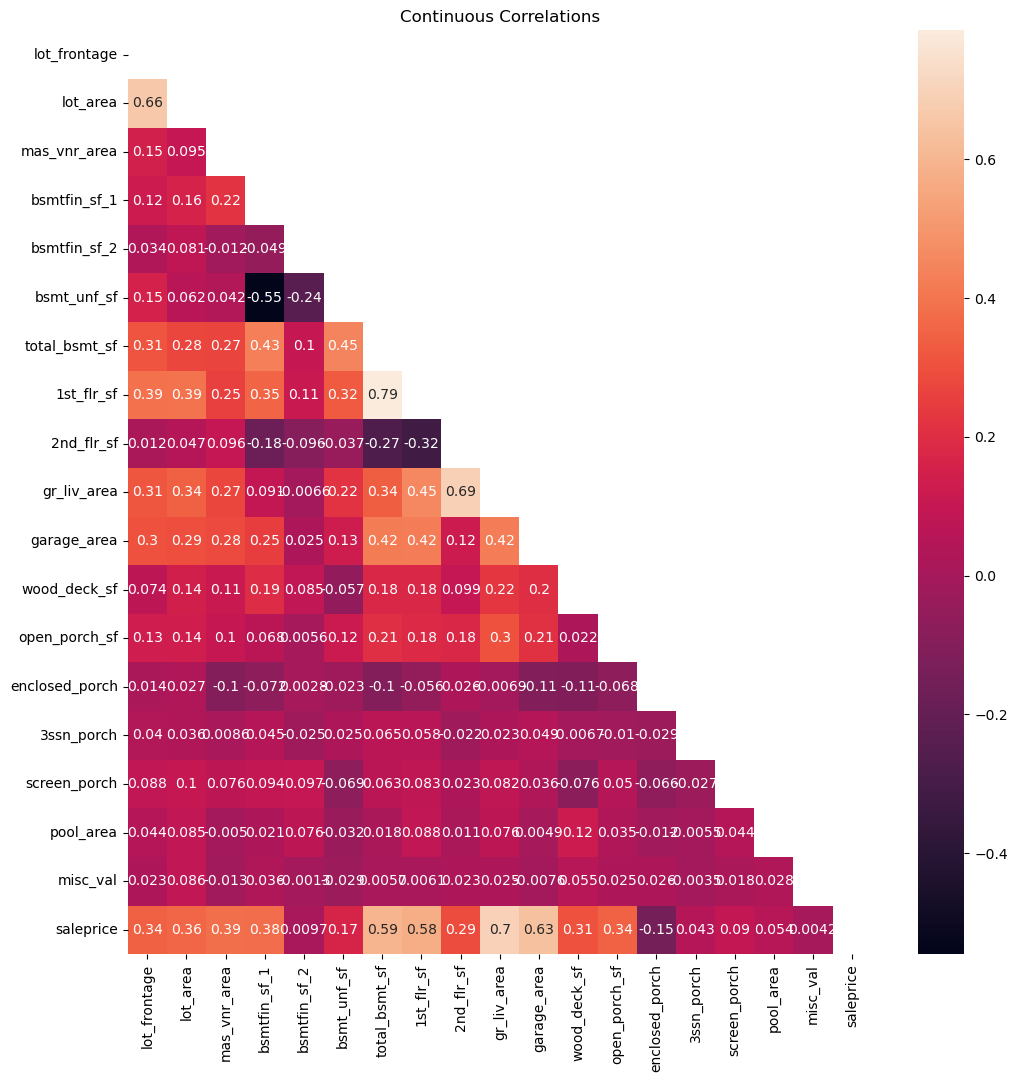

In [1010]:
continuous_corrs = plot_corr_heatmap(CONTINUOUS, 'Continuous')

correlative_factors.update(continuous_corrs[1].to_dict())

### Ordinal

Theres clearly a lot of value in these ranked qualitative values, we'll make them numeric and see if we can get some more value. 

       
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

The following columns use this system:  
- exter_qual
- exter_cond
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- heating_qc
- kitchen_qual
- garage_qual
- garage_cond

In [1011]:
# functions to rank Ordinal quality ratings
def ordinal_to_numeric_expo(val):
    if val == 'Ex':
        return 4
    elif val == 'Gd':
        return 3
    elif val == 'TA':
        return 2
    elif val == 'Fa':
        return 1
    elif val == 'Po':
        return 0
    else:
        pass

def ordinal_to_numeric_glqna(val):
    if val == 'GLQ':
        return 6
    elif val == 'ALQ':
        return 5
    elif val == 'BLQ':
        return 4
    elif val == 'Rec':
        return 3
    elif val == 'LwQ':
        return 2
    elif val == 'Unf':
        return 1
    elif val == 'NA':
        return 0
    else:
        pass

Find the columns that use the 'Ex - Po' rating schema

In [1012]:
rank_words = ['Ex', 'Gd', 'TA','Fa', 'Po']
rank_words = pd.Series(rank_words)
columns_to_fix = []

# find columns, append to columns to fix
for col in house_train[ORDINAL].columns:
    word_check = rank_words.isin(house_train[ORDINAL][col])
    if word_check.sum() > 0:
        columns_to_fix.append(col)
        
# convert columns to numeric values
for col in columns_to_fix:
    house_train[col] = [ordinal_to_numeric_expo(val) for val in house_train[col]]

Basements

In [1013]:
basement_cols = ['bsmtfin_type_1', 'bsmtfin_type_2']

for col in basement_cols:
    house_train[col] = [ordinal_to_numeric_glqna(val) for val in house_train[col]]

Ordinal Correlations

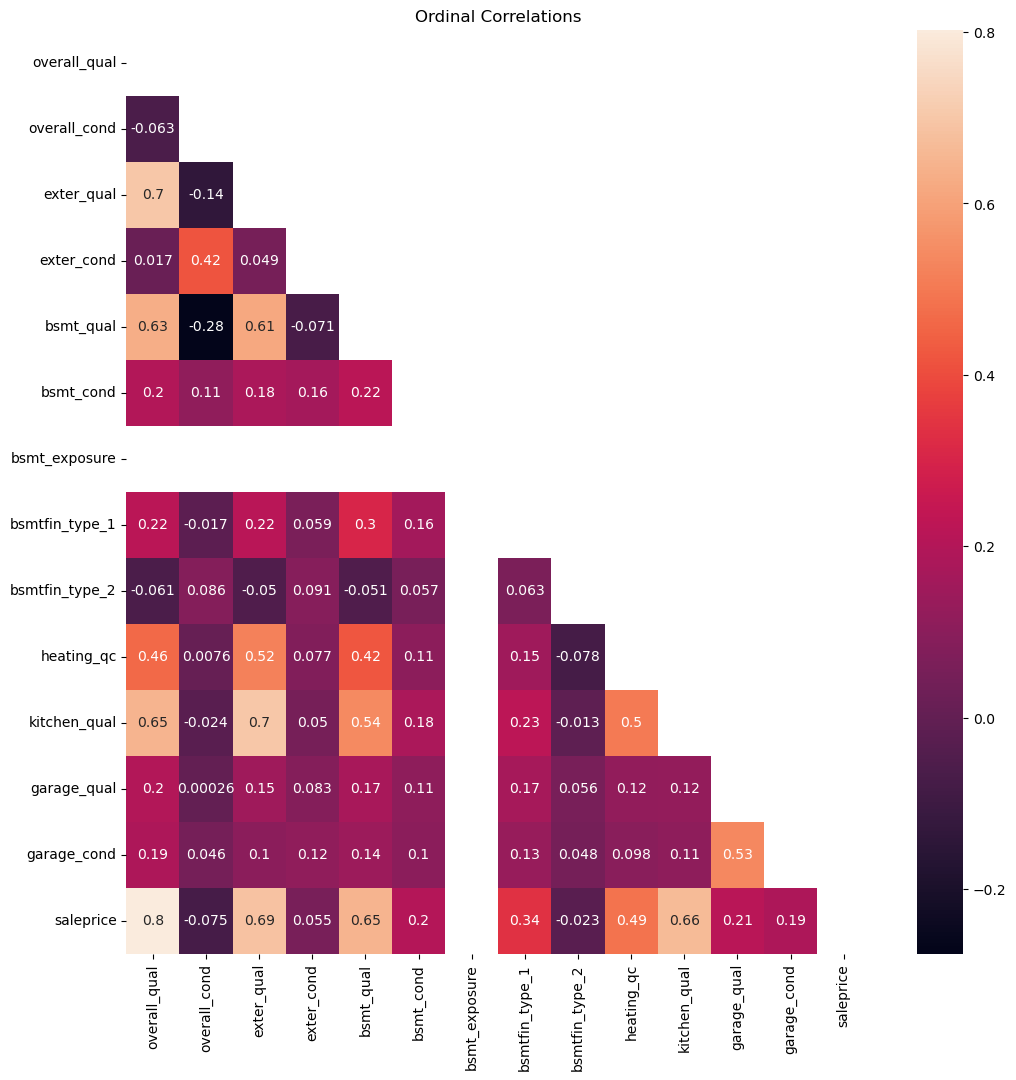

In [1014]:
ordinal_corrs = plot_corr_heatmap(ORDINAL, 'Ordinal')

correlative_factors.update(ordinal_corrs[1].to_dict())

### Nominal

Condition 1 (Nominal): Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

These seem important! location, location, location. Let's make them numerical too. 

In [1015]:
# get dummies and concat
house_train = pd.concat([house_train, pd.get_dummies(house_train['condition_1'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['condition_1']).columns.to_list():
    NOMINAL.append(x)

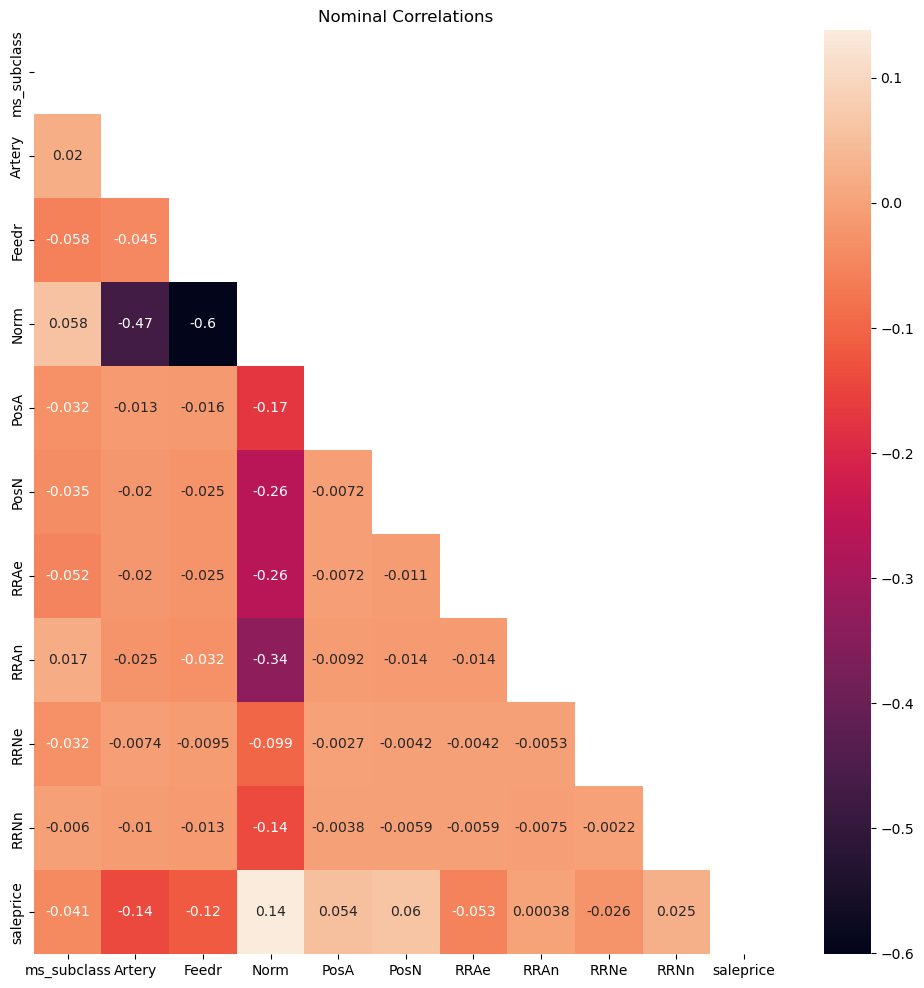

In [1016]:
nominal_corrs = plot_corr_heatmap(NOMINAL, 'Nominal')

correlative_factors.update(nominal_corrs[1].to_dict())

'Norm' 'PosA' and 'PosN' have a weak positive correlative effect and being near a railroad or busy thruway has a weak negative correlative effect

# Find Most Correlative Factors
- Gives us a place to start building new features from

In [1017]:
correlative_factors = {k:v for k,v in correlative_factors.items() if v > .25}

correlative_factors

{'year_built': 0.6133735889830514,
 'year_remod/add': 0.5837380874584129,
 'bsmt_full_bath': 0.25564090996705496,
 'full_bath': 0.5664139428435248,
 'half_bath': 0.29477219967371293,
 'totrms_abvgrd': 0.4584786428624373,
 'fireplaces': 0.46158654088585443,
 'garage_yr_blt': 0.5728022930650781,
 'garage_cars': 0.6397321728460715,
 'saleprice': 1.0,
 'lot_frontage': 0.3412498873873694,
 'lot_area': 0.35508312755012217,
 'mas_vnr_area': 0.3850854278446958,
 'bsmtfin_sf_1': 0.37941617077060186,
 'total_bsmt_sf': 0.5948422198506701,
 '1st_flr_sf': 0.575111251989233,
 '2nd_flr_sf': 0.2905763695307002,
 'gr_liv_area': 0.6962609002437377,
 'garage_area': 0.6349737404935624,
 'wood_deck_sf': 0.3068694684997656,
 'open_porch_sf': 0.3448736799585195,
 'overall_qual': 0.8026876277683008,
 'exter_qual': 0.6850562950278067,
 'bsmt_qual': 0.6499842246917428,
 'bsmtfin_type_1': 0.3354522446119946,
 'heating_qc': 0.48668074799525113,
 'kitchen_qual': 0.664372357526454}

# Missing Values for Correlative Factors

In [1018]:
missing = house_train[correlative_factors.keys()].isnull().sum()

missing

year_built          0
year_remod/add      0
bsmt_full_bath      1
full_bath           0
half_bath           0
totrms_abvgrd       0
fireplaces          0
garage_yr_blt     114
garage_cars         1
saleprice           0
lot_frontage      305
lot_area            0
mas_vnr_area       20
bsmtfin_sf_1        1
total_bsmt_sf       1
1st_flr_sf          0
2nd_flr_sf          0
gr_liv_area         0
garage_area         1
wood_deck_sf        0
open_porch_sf       0
overall_qual        0
exter_qual          0
bsmt_qual          49
bsmtfin_type_1     49
heating_qc          0
kitchen_qual        0
dtype: int64

`lot_frontage`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

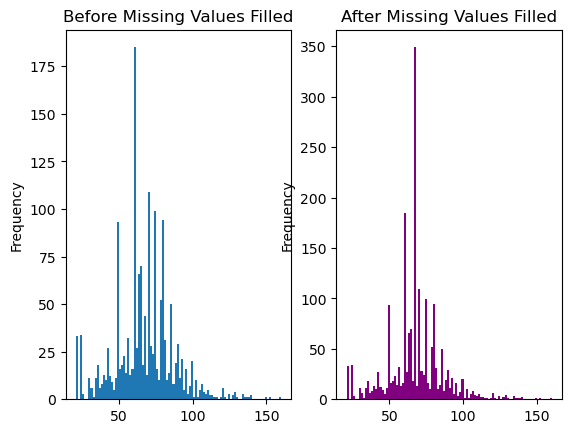

In [1019]:
before = house_train['lot_frontage'].copy()
# median is 67, mean is 68, fill with mean
house_train['lot_frontage'].fillna(house_train['lot_frontage'].mean(), inplace = True)

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['lot_frontage'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`mas_vnr_area`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

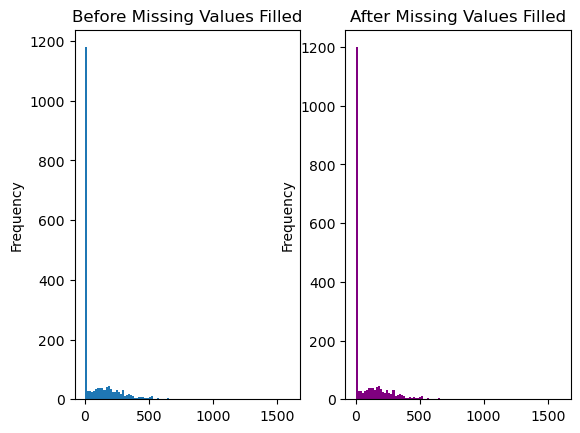

In [1020]:
before = house_train['mas_vnr_area'].copy()

house_train['mas_vnr_area'].fillna(0, inplace=True) # 0 is the mode, overwhelmingly the case

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['mas_vnr_area'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmtfin_type_1`

In [1021]:
len(house_train.query('bsmtfin_type_1 == 1 and bsmtfin_type_1.notna()'))
len(house_train.query('bsmtfin_type_1.notna()'))


1870

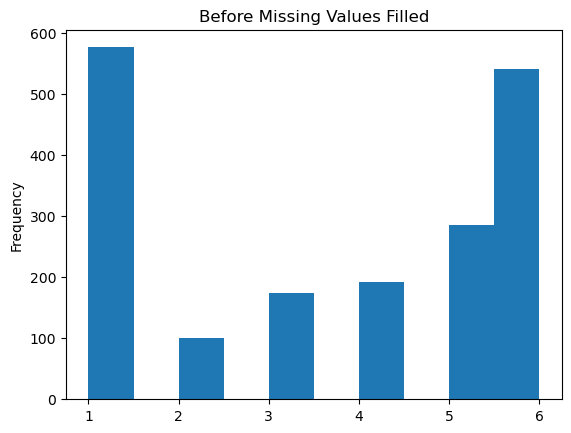

In [1022]:
before = house_train['bsmtfin_type_1'].plot.hist(title='Before Missing Values Filled')
weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
for x in range(1,7):
    weights.append(
    len(house_train.query(f'bsmtfin_type_1 == {x} and bsmtfin_type_1.notna()'))/
    len(house_train.query(f'bsmtfin_type_1.notna()'))
    )

# use proportions as probability weights for random assignment of values
house_train['bsmtfin_type_1'].fillna(np.random.choice(np.arange(1,7), p=weights), inplace=True)

`bsmt_full_bath`

In [1023]:
house_train.bsmt_full_bath.describe()

count    1918.000000
mean        0.407716
std         0.513341
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: bsmt_full_bath, dtype: float64

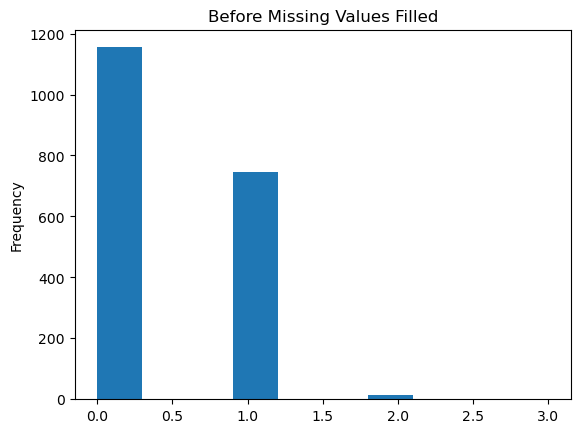

In [1024]:
house_train.bsmt_full_bath.plot.hist(title = 'Before Missing Values Filled')

weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
for x in range(0,3):
    weights.append(
    len(house_train.query(f'bsmt_full_bath == {x} and bsmt_full_bath.notna()'))/
    len(house_train.query(f'bsmt_full_bath.notna()'))
    )

# normalize so numpy doesn't flag .9998 as not being 1.0
weights = np.array(weights)
weights /= weights.sum()

# use proportions as probability weights for random assignment of values
house_train['bsmt_full_bath'].fillna(np.random.choice(np.arange(0,3), p=weights), inplace=True)



`bsmtfin_sf_1`

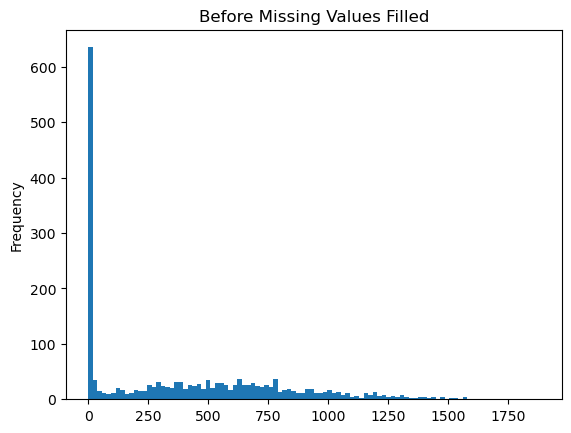

In [1025]:
house_train.bsmtfin_sf_1.plot.hist(title='Before Missing Values Filled', bins=100)

house_train['bsmtfin_sf_1'].fillna(0, inplace=True) # 0 is the mode, overwhelmingly the case

`garage_yr_blt`

0    2005.0
Name: garage_yr_blt, dtype: float64


<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

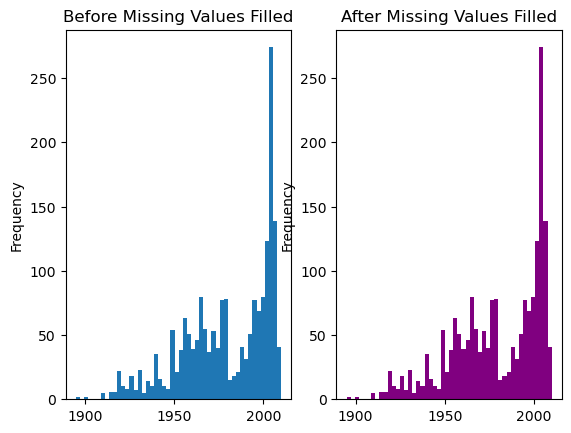

In [1026]:

before = house_train['garage_yr_blt']

print(house_train.garage_yr_blt.mode())
# the mean and median for garage_yr_built are all 1978, the mode is 2005
house_train['garage_yr_blt'].fillna(2005, inplace=True)

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_yr_blt'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmt_qual`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

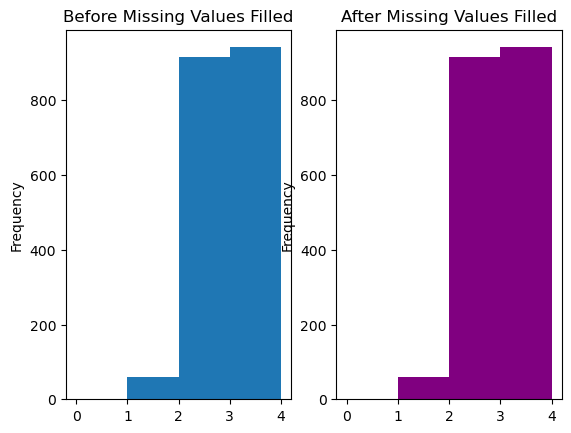

In [1027]:
before = house_train['bsmt_qual'] # mode is 2, median is 3, mean is 2.5
house_train['bsmt_qual'].fillna(house_train.bsmt_qual.mean(), inplace=True)

fix, axes = plt.subplots(1, 2)
before.plot.hist(bins=4, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_qual'].plot.hist(bins=4, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`garage_area` and `garage_cars`

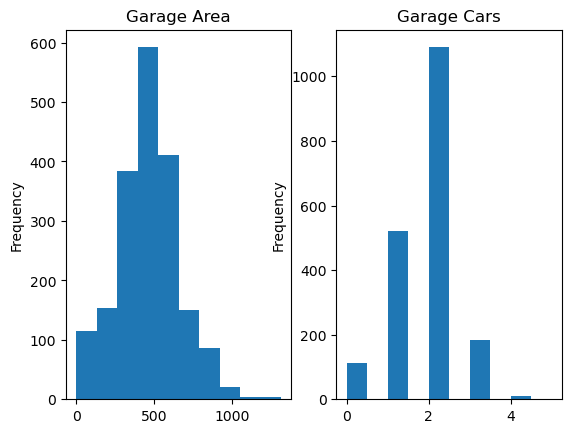

In [1028]:
# both of these are just missing 1 value and are close to normally distributed, so we'll insert the median..

fix, axes = plt.subplots(1,2)
house_train.garage_area.plot.hist(title='Garage Area', ax=axes[0])
house_train.garage_cars.plot.hist(title='Garage Cars', ax=axes[1])

for col in ['garage_cars', 'garage_area']:
    house_train[col].fillna(house_train[col].median(), inplace=True)

`total_bsmt_sqft`

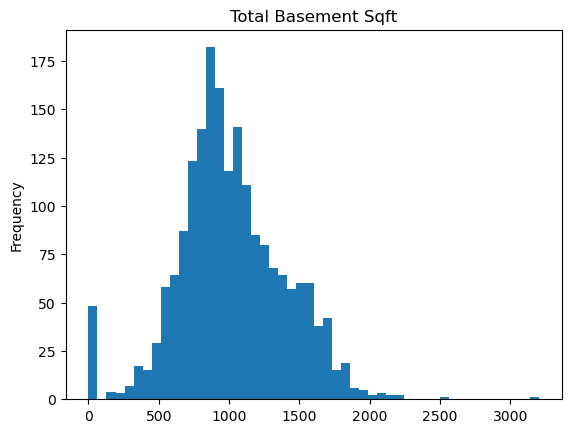

In [1029]:
house_train['total_bsmt_sf'].plot.hist(bins=50, title= 'Total Basement Sqft')

house_train['total_bsmt_sf'].fillna(house_train['total_bsmt_sf'].mean(), inplace=True)

In [1030]:
house_train[correlative_factors.keys()].isnull().sum()

year_built        0
year_remod/add    0
bsmt_full_bath    0
full_bath         0
half_bath         0
totrms_abvgrd     0
fireplaces        0
garage_yr_blt     0
garage_cars       0
saleprice         0
lot_frontage      0
lot_area          0
mas_vnr_area      0
bsmtfin_sf_1      0
total_bsmt_sf     0
1st_flr_sf        0
2nd_flr_sf        0
gr_liv_area       0
garage_area       0
wood_deck_sf      0
open_porch_sf     0
overall_qual      0
exter_qual        0
bsmt_qual         0
bsmtfin_type_1    0
heating_qc        0
kitchen_qual      0
dtype: int64

# Feature Engineering

### Neighborhood Group

In [1031]:
group_by_neighborhood = house_train.groupby('neighborhood')['saleprice'].median().sort_values(ascending=False)

neighbor_hood_dict = {}
for i, val in enumerate(group_by_neighborhood):
    neighbor_hood_dict.update({group_by_neighborhood.index[i]:i})

house_train['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in house_train.neighborhood]

In [1032]:
# .73, nice!
neighborhood_corr = house_train[['neighborhood_price_rank', 'saleprice']].corr()

correlative_factors.update(neighborhood_corr['saleprice'].to_dict())

### Age of Home

In [1033]:
house_train['house_age'] = house_train['yr_sold'] - house_train['year_built']

In [1034]:
# .60
age_corr = house_train[['house_age', 'saleprice']].corr()

correlative_factors.update(age_corr['saleprice'].to_dict())

### Age of Garage

In [1035]:
house_train['garage_age'] = house_train['yr_sold'] - house_train['garage_yr_blt'] 
garage_corr = house_train[['garage_age', 'saleprice']].corr()

correlative_factors.update(age_corr['saleprice'].to_dict())

In [1036]:
# house_train.plot.scatter(x='total_bsmt_sf', y='saleprice')

### Bubble Burst

In [1037]:
meltdown_list = []
for idx, row in house_train.iterrows():
    if row['sale_type'] == 'New' and row['house_age'] < 3:
        meltdown_list.append(1)
    else:
        meltdown_list.append(0)

house_train['meltdown'] = meltdown_list


meltdown_corr = house_train[['meltdown', 'saleprice']].corr()

meltdown_corr
# correlative_factors.update(neighborhood_corr['saleprice'].to_dict())

,meltdown,saleprice
meltdown,1.000000,0.259968
saleprice,0.259968,1.000000


Sanity check
- quick LinReg to see how we're moving along

In [1087]:
correlative_factors

{'year_built': 0.6133735889830514,
 'year_remod/add': 0.5837380874584129,
 'bsmt_full_bath': 0.25564090996705496,
 'full_bath': 0.5664139428435248,
 'half_bath': 0.29477219967371293,
 'totrms_abvgrd': 0.4584786428624373,
 'fireplaces': 0.46158654088585443,
 'garage_yr_blt': 0.5728022930650781,
 'garage_cars': 0.6397321728460715,
 'saleprice': 1.0,
 'lot_frontage': 0.3412498873873694,
 'lot_area': 0.35508312755012217,
 'mas_vnr_area': 0.3850854278446958,
 'bsmtfin_sf_1': 0.37941617077060186,
 'total_bsmt_sf': 0.5948422198506701,
 '1st_flr_sf': 0.575111251989233,
 '2nd_flr_sf': 0.2905763695307002,
 'gr_liv_area': 0.6962609002437377,
 'garage_area': 0.6349737404935624,
 'wood_deck_sf': 0.3068694684997656,
 'open_porch_sf': 0.3448736799585195,
 'overall_qual': 0.8026876277683008,
 'exter_qual': 0.6850562950278067,
 'bsmt_qual': 0.6499842246917428,
 'bsmtfin_type_1': 0.3354522446119946,
 'heating_qc': 0.48668074799525113,
 'kitchen_qual': 0.664372357526454,
 'neighborhood_price_rank': -0.73

In [1182]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score


X = house_train[[x for x in correlative_factors.keys() if x not in ['saleprice', 'garage_yr_blt', 'year_built', 'year_remod/add',
                                                                    'gr_liv_area']]]
y = house_train.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, y)


X_train.isnull().sum()

mlr = LinearRegression()
# train it

X_train.isnull().sum()
scores_1 = (cross_val_score(LinearRegression(), X_train, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
# cross val score
scores_1.mean()



0.9020690347222218

In [1183]:
#calculate residuals by creating predictions
mlr.fit(X_train,y_train)
preds = mlr.predict(X_train)
resid = y_train - preds

Text(0.5, 1.0, 'Predicted vs. Actual')

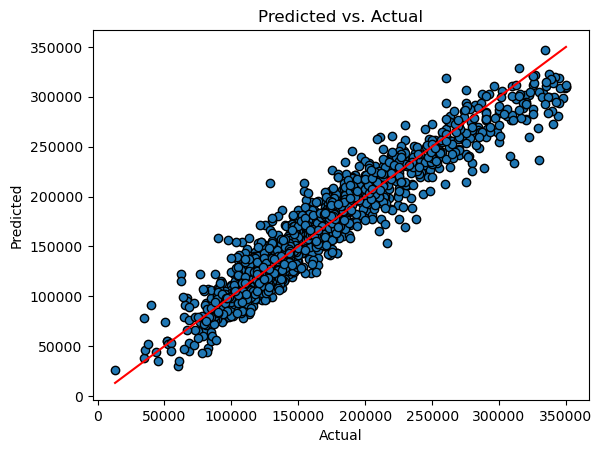

In [1184]:
fig, ax = plt.subplots()
ax.scatter(y_train, preds, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],'r')

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')

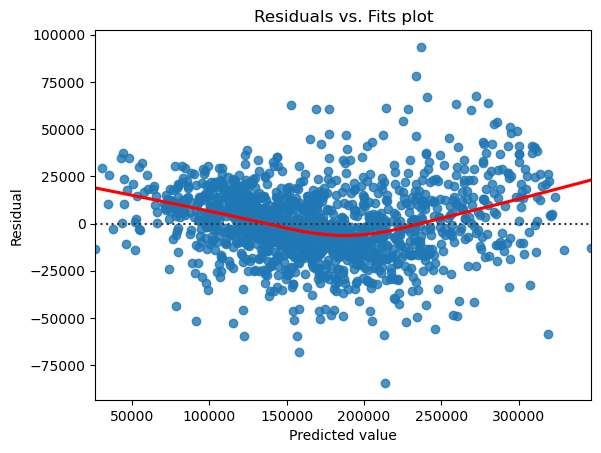

In [1185]:


sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

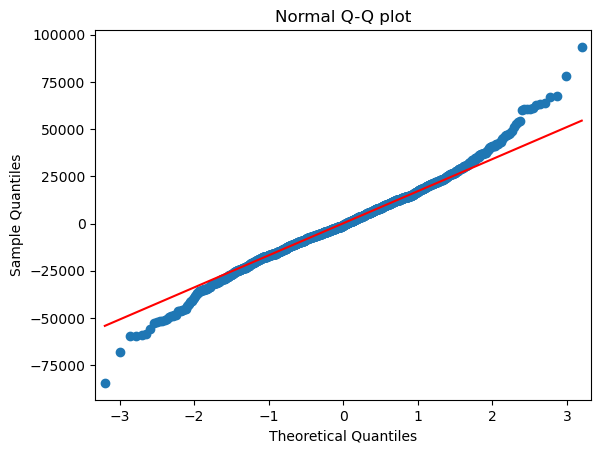

In [1186]:

sm.qqplot(resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot');

In [1187]:
import statsmodels.api as sm

X_sm = sm.add_constant(X_train)

res = sm.OLS(y_train,X_sm).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     573.1
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:41:13   Log-Likelihood:                -16219.
No. Observations:                1439   AIC:                         3.249e+04
Df Residuals:                    1414   BIC:                         3.262e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -5.534e+04   6779.707     -8.162      0.000   -6.86e+04    -4.2e+04
bsmt_full_bath           4646.1827   1332.313      3.487      0.001    2032.659    7259.706
full_bath               -2426.4766   1453.226     -1.670      0.095   -5277.186     424.233
half_bath               -1984.4951   1535.539     -1.292      0.196   -4996.674    1027.684
totrms_abvgrd            -887.7868    599.387     -1.481      0.139   -2063.570     287.996
fireplaces               6664.8509    983.880      6.774      0.000    4734.830    8594.871
garage_cars              1333.6865   1614.060      0.826      0.409   -1832.523    4499.896
lot_frontage               88.7103     35.231      2.518      0.012      19.600     157.821
lot_area                    1.4663      0.208      7.053      0.000       1.058       1.874
mas_vnr_area               12.7332      3.854      3.304      0.001       5.172      20.294
bsmtfin_sf_1               13.8428      2.179      6.353      0.000       9.568      18.117
total_bsmt_sf              12.7871      2.494      5.126      0.000       7.894      17.680
1st_flr_sf                 41.9207      3.464     12.103      0.000      35.126      48.715
2nd_flr_sf                 42.9982      2.919     14.730      0.000      37.272      48.724
garage_area                19.3152      5.814      3.322      0.001       7.910      30.721
wood_deck_sf               10.2278      4.409      2.320      0.020       1.579      18.877
open_porch_sf              18.1640      8.428      2.155      0.031       1.631      34.697
overall_qual             1.043e+04    687.232     15.181      0.000    9084.471    1.18e+04
exter_qual               7771.1156   1578.248      4.924      0.000    4675.157    1.09e+04
bsmt_qual                5856.8476   1256.585      4.661      0.000    3391.876    8321.819
bsmtfin_type_1            581.9832    389.712      1.493      0.136    -182.492    1346.458
heating_qc               3688.5890    648.564      5.687      0.000    2416.338    4960.840
kitchen_qual             1.039e+04   1226.279      8.475      0.000    7987.035    1.28e+04
neighborhood_price_rank -1030.8924    120.062     -8.586      0.000   -1266.412    -795.373
house_age                 -54.5336     32.715     -1.667      0.096    -118.709       9.642
==============================================================================
Omnibus:                       55.623   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.437
Skew:                           0.162   Prob(JB):                     8.68e-31
Kurtosis:                       4.485   Cond. No.                     1.33e+05
==============================================================================

Notes:
[1] Standard Errors assum